In [3]:
library(ggplot2)
library(ggpubr)
library(reshape2)
library(dplyr)
library(data.table)
library(Seurat)
library(SeuratDisk)
setwd('/home/wyh/scdata/combined_data/Epithelial')

Warning message:
“package ‘reshape2’ was built under R version 4.0.5”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt


Attaching SeuratObject

Attaching sp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



# calculate pvalue by permutation test 

In [160]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$orig.ident = patient_info$NewSample.ID

patient_info$metastasis.type[patient_info$metastasis.type %in% c("P","P_LI")] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type, levels = c("P","P_LN","P_LM"))
patient_info$progression.type.short = factor(patient_info$progression.type.short, levels = c("Inflam","Proli","Mix","None"))



ngenes = 100
# K_range = c(23,26,32,36,44,46)
K_range = c(23)

premutation_time = 500
for(K in K_range){
    program_num = K
    program_score = matrix(0,nrow = K,ncol = premutation_time+1)
    #celltype_info = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno/patient_GM_score_",program_num,"GM_100genes.csv"),row.names = 1)
    celltype_info = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/normalize/patient_GM_score_",program_num,"GM_",ngenes,"genes.csv"),row.names = 1)
    colnames(celltype_info) = paste0("score_GM",1:program_num)
    orig.ident = lapply(rownames(celltype_info),
        FUN = function(i){
        data_split = unlist(strsplit(i,split = "_"))
        name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
        #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
            return(name)
                          })
    orig.ident = unlist(orig.ident)
    celltype_info$orig.ident = orig.ident
    celltype_info = as.data.frame(celltype_info)
    celltype_info$barcode = rownames(celltype_info)
    for(isample_time in 1:(premutation_time+1)){
        if(isample_time==(premutation_time+1)){
            celltype_info$orig.ident_new = celltype_info$orig.ident
        }else{
            celltype_info$orig.ident_new = sample(celltype_info$orig.ident,length(celltype_info$orig.ident))
        }
       
        # 计算得分
        GM_index = c(1:program_num)
        sample_score = array(0,dim = c(length(unique(celltype_info$orig.ident_new)),ncol(celltype_info)-3),dimnames = list(unique(celltype_info$orig.ident_new),paste0("score_GM",GM_index)))
        for(iGM in paste0("score_GM",GM_index)){
            data_analysis = celltype_info[,c(iGM,"orig.ident_new")]
            colnames(data_analysis) = c("GM","orig.ident_new")
            score_summary = setDT(data_analysis)[,list(Mean=mean(GM), Max=max(GM), Min=min(GM), Median=as.numeric(median(GM)), Std=sd(GM)), by=orig.ident_new]
            score_summary = as.data.frame(score_summary)
            rownames(score_summary) = score_summary[,"orig.ident_new"]
            sample_score[rownames(score_summary),iGM] = score_summary[,"Mean"]
        }
        sample_score = as.data.frame(sample_score)
        #colnames(sample_score) = c("score_GM1_E2F","score_GM2_G2M","score_GM3_Metal","score_GM4_Glandular","score_GM5_cEMT","score_GM6_Interferon","score_GM7_Hypoxia","score_GM8_P53")
        sample_score$NewSample.ID = rownames(sample_score)

        myfun = function(i){
            i = (i-min(i))/(max(i)-min(i))
        }

        for(i in 1:program_num){
            sample_score[,i] = myfun(sample_score[,i])
        }

        program_score[,isample_time] = apply(sample_score[,1:program_num],MARGIN = 2,FUN = IQR)
        
    }
    rownames(program_score) = paste0("score_GM",c(1:K))
    program_score = as.data.frame(program_score)
    score_pvalue = c()
    for(iGM in 1:K){
        gene_module = paste0("score_GM",iGM)
        score_pvalue[iGM] = sum(program_score[gene_module,1:premutation_time]>program_score[gene_module,(premutation_time+1)])/premutation_time
    }
    names(score_pvalue) =  paste0("score_GM",1:K)
    score_pvalue = sort(score_pvalue)
    patient_shares = names(score_pvalue[score_pvalue<=0.05])
    patient_shares = gsub("score_GM","",patient_shares)
    patient_shares = as.numeric(patient_shares)
    write.csv(score_pvalue,paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/pvalue_score_",program_num,"GM_",ngenes,"genes.csv"))  

    write.csv(patient_shares,paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/pvalue_patient_shared_state_",program_num,"GM_",ngenes,"genes.csv")) 

    
    sample_score$NewSample.ID = rownames(sample_score)
    fibroblast_ratio_all = left_join(sample_score,patient_info[rownames(sample_score),])

    #fibroblast_ratio_all = fibroblast_ratio_all[fibroblast_ratio_all$Tumors.for.scRNA.seq.short=="P",]
    #fibroblast_ratio_all = fibroblast_ratio_all[fibroblast_ratio_all$histological.type.short %in% "adeno",]

    fibroblast_ratio_all$number =  as.data.frame.array(table(celltype_info$orig.ident))[fibroblast_ratio_all$NewSample.ID,]
    fibroblast_ratio_all$orig.ident = fibroblast_ratio_all$NewSample.ID
    rownames(fibroblast_ratio_all) = fibroblast_ratio_all$orig.ident
    fibroblast_little_patient = rownames(fibroblast_ratio_all)[fibroblast_ratio_all$number<50]

    fibroblast_ratio_all = fibroblast_ratio_all[!fibroblast_ratio_all$orig.ident %in% fibroblast_little_patient,]
    
    
    fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio_all$Tumors.for.scRNA.seq.short=="P",]
    fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]
    data_plot = fibroblast_ratio[,c(paste0("score_GM",patient_shares),"metastasis.type")]
    data_plot_melt = reshape2::melt(data_plot)
    colnames(data_plot_melt) = c("metastasis.type","variable","Freq")

    pdf(paste0("/home/wyh/scdata/combined_data//Epithelial/group_compare/adeno_p/pvalue_adeno_epithelial_metastasis.type_",program_num,"_",ngenes,"genes.pdf"),width = 30,height = 5)
    print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type)) + geom_boxplot()+facet_grid(. ~variable)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
             axis.text.y = element_text(color="black"),
             axis.title=element_text())+ggtitle("")+
          stat_compare_means(comparisons = list(
       c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
      ),method = "wilcox.test",label="p.signif"))
    dev.off()
    
}


Joining, by = "NewSample.ID"
Using metastasis.type as id variables



## figure: heatmap of patient scores

In [6]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$orig.ident = patient_info$NewSample.ID

patient_info$metastasis.type[patient_info$metastasis.type %in% c("P","P_LI")] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type, levels = c("P","P_LN","P_LM"))
patient_info$progression.type.short = factor(patient_info$progression.type.short, levels = c("Inflam","Proli","Mix","None"))

In [13]:
ngenes = 100
K_range = c(23)
for(K in K_range){
    program_num = K

    #celltype_info = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno/patient_GM_score_",program_num,"GM_100genes.csv"),row.names = 1)
    celltype_info = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/normalize/patient_GM_score_",program_num,"GM_",ngenes,"genes.csv"),row.names = 1)
    colnames(celltype_info) = paste0("score_GM",1:program_num)
    orig.ident = lapply(rownames(celltype_info),
        FUN = function(i){
        data_split = unlist(strsplit(i,split = "_"))
        name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
        #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
            return(name)
                          })
    orig.ident = unlist(orig.ident)
    celltype_info$orig.ident = orig.ident
    celltype_info = as.data.frame(celltype_info)
    celltype_info$barcode = rownames(celltype_info)


    GM_index = c(1:program_num)
    sample_score = array(0,dim = c(length(unique(celltype_info$orig.ident)),ncol(celltype_info)-2),dimnames = list(unique(celltype_info$orig.ident),paste0("score_GM",GM_index)))
    for(iGM in paste0("score_GM",GM_index)){
        data_analysis = celltype_info[,c(iGM,"orig.ident")]
        colnames(data_analysis) = c("GM","orig.ident")
        score_summary = setDT(data_analysis)[,list(Mean=mean(GM), Max=max(GM), Min=min(GM), Median=as.numeric(median(GM)), Std=sd(GM)), by=orig.ident]
        score_summary = as.data.frame(score_summary)
        rownames(score_summary) = score_summary[,"orig.ident"]
        sample_score[rownames(score_summary),iGM] = score_summary[,"Mean"]
    }
    sample_score = as.data.frame(sample_score)
    #colnames(sample_score) = c("score_GM1_E2F","score_GM2_G2M","score_GM3_Metal","score_GM4_Glandular","score_GM5_cEMT","score_GM6_Interferon","score_GM7_Hypoxia","score_GM8_P53")
    sample_score$NewSample.ID = rownames(sample_score)

    myfun = function(i){
        i = (i-min(i))/(max(i)-min(i))
    }

    for(i in 1:program_num){
        sample_score[,i] = myfun(sample_score[,i])
    }
}

In [14]:
library(pheatmap)
library(data.table)

In [61]:
write.csv(sample_score,"../submit/figure_data/heatmap_GM_score.csv")

In [5]:
setwd("/home/wyh/scdata/combined_data/Epithelial/group_compare/")

In [17]:
sample_score = read.csv("../submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_score = sample_score[,1:23]
sample_score$metastasis.type = patient_info[rownames(sample_score),"metastasis.type"]
sample_score = sample_score[c(which(sample_score$metastasis.type=="P"),which(sample_score$metastasis.type=="P_LN"),which(sample_score$metastasis.type=="P_LM")),]

In [12]:
library(pheatmap)
library(ComplexHeatmap)

In [20]:
sample_score = sample_score[,1:23]
shared_state = c(1,3,5,6,7,8,16)
row_annotation = rep("patient_specific",23)
names(row_annotation) = paste0("score_GM",c(1:23))
row_annotation[shared_state] = "patient_shared"
col_annotation = sample_score$metastasis.type

In [24]:
# third version
col_annotation = as.character(col_annotation)
col_annotation[col_annotation %in% c("P_LN","P_LM")] = "P_Metas"

annoCol<-list(GM_state=c(patient_shared = "#CD3333", patient_specific="#2078B5"),
             metastasis.type = c(P = "#0073C2",P_Metas = "#EFC000"))

In [ ]:
# https://jokergoo.github.io/2021/03/05/cluster-groups-in-complexheatmap/

In [50]:
fa = col_annotation
fa_col = c("P" = "#0073C2", "P_Metas" = "#EFC000")
GM_state_color = c(patient_shared = "#CD3333", patient_specific="#2078B5")
col_fun = colorRampPalette(c("white","firebrick3"))(50)

In [65]:
pdf("./adeno_p/heatmap_GM_scoreV8.pdf",height = 8,width = 9)
dend2 = cluster_within_group(t(sample_score), fa)
Heatmap(t(sample_score), cluster_columns = dend2, column_split = 2,col = col_fun,show_column_names = FALSE,
    row_title = "cluster_within_group",
    top_annotation = HeatmapAnnotation(foo = fa, col = list(foo = fa_col)),
       left_annotation = rowAnnotation(GM_state = row_annotation,col = list(GM_state = GM_state_color)))
dev.off()

png 
  2

## figure: overlap between genes of gene modules

In [ ]:
# https://rdrr.io/bioc/GeneOverlap/man/GeneOverlap.html

In [ ]:
library(pheatmap)

In [78]:
K = 23
gene_list = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_",K,".csv"),row.names = 1)
patient_shared = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/patient_shared_state_",K,"GM_100genes.csv"),row.names = 1)
gene_list = gene_list[1:100,]
gene_list = gene_list[,c(1,3,5,6,7,8,16)]

In [135]:
n = 31906
a = 100
b = 100

gene_overlap = matrix(0,nrow = 7,ncol = 7)
colnames(gene_overlap) = paste0("GM",c(1,3,5,6,7,8,16))
rownames(gene_overlap) = paste0("GM",c(1,3,5,6,7,8,16))
for(i in 1:7){
    for(j in 1:7){
        t = length(intersect(gene_list[,i],gene_list[,j]))
        gene_overlap[i,j] = -log10(sum(dhyper(t, a, n - a, b)))
    }
}

gene_overlap[gene_overlap>10] = 20
pheatmap(gene_overlap,filename = "../overlap.pdf",cellheight = 25,cellwidth = 25)

## figure: enrichment analysis

In [14]:
library(clusterProfiler)
library(ggplot2)

# go_bp = read.gmt("D:/postgraduate/database/msigdb/c5.go.bp.v2022.1.Hs.symbols.gmt")
for(K in c(23)){
  gene_list = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_",K,".csv"),row.names = 1)
  
  patient_shared = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/patient_shared_state_",K,"GM_100genes.csv"),row.names = 1)

  gene_list = gene_list[1:100,]
  gene_list = as.list(gene_list)
  #gene_list = gene_list[patient_shared[,1]]
  names(gene_list) = gsub("X","GM",names(gene_list))
  HALL_marks = read.csv("/home/wyh/scdata/knowledge_based/hallmarks.csv",row.names = 1)
  HALL_marks$term = gsub(pattern = "HALLMARK_",replacement = "",x = HALL_marks$term)
  # gene_list = gene_list[c(1,3,5,6,7,8,16)]
  
  a = compareCluster(geneClusters = gene_list[c(8,1,16,5,3,7,6,18,20,21,10,14,2,12,17,22,19,9,15,11,4,23,13)],fun = enricher,TERM2GENE = HALL_marks)
  # ggsave(paste0("./epithelial/group_compare/adeno_p/enrich_GM_",K,'.png'),dotplot(a),width = 15,height = 10) 
}

In [61]:
pdf("./submit/figure/enrichment_allV5.pdf",height = 5,width = 10)
dotplot(a)+theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"))
dev.off()

png 
  2

## table: patient-specific gene module and TME 

In [34]:
setwd("/home/wyh/scdata/combined_data/Epithelial/group_compare/")
sample_score = read.csv("/home/wyh/scdata/combined_data/Epithelial//submit/figure_data/heatmap_GM_score.csv",row.names = 1)

In [35]:
patient_shares = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/pvalue_patient_shared_state_",23,"GM_",100,"genes.csv"),row.names = 1)

In [36]:
patient_specific_GM = apply(sample_score[,1:23],2,
                            FUN = function(i){rownames(sample_score)[which(i==max(i))]})[setdiff(c(1:23),patient_shares[,1])]

In [37]:
subtype_entropy = read.csv("/home/wyh/scdata/submit/supplymentary tables/Suppmentary table _Entropy.csv",row.names = 1)

In [39]:
patient_specific_subtype = rownames(subtype_entropy)[subtype_entropy$Entropy.Value<0.625]

In [3]:
celltype_info = readRDS("/home/wyh/scdata/combined_data/meta_data/celltype20230610/combined_celltype_include_normal20230610.RDS")

In [5]:
orig.ident = lapply(rownames(celltype_info),
    FUN = function(i){
    data_split = unlist(strsplit(i,split = "_"))
    name = paste(data_split[1:(length(data_split)-1)],collapse = '_')
    #name = do.call(data_split[paste,args = data_split[1:(length(data_split)-1)]])
        return(name)
                      })
orig.ident = unlist(orig.ident)
celltype_info$orig.ident = orig.ident
celltype_info = as.data.frame(celltype_info)

In [9]:
celltype_info$subtype = as.character(celltype_info$subtype)

In [28]:
patient_specific_TME_num = as.data.frame.array(table(celltype_info[celltype_info$subtype %in% patient_specific_subtype,][,c('orig.ident',"subtype")]))

In [42]:
patient_specific_TME = apply(patient_specific_TME_num,2,
                            FUN = function(i){rownames(patient_specific_TME_num)[which(i==max(i))]})

In [44]:
write.csv(patient_specific_TME,"/home/wyh/scdata/combined_data/Epithelial/patient_specific/patient_specific_TME231203.csv")

In [45]:
write.csv(patient_specific_GM,"/home/wyh/scdata/combined_data/Epithelial/patient_specific/patient_specific_GM231203.csv")

In [46]:
patient_intersect = intersect(patient_specific_TME,patient_specific_GM)
patient_intersect

[1] "GBC_051_P" "GBC_028_P" "GBC_084_P" "GBC_083_P"

## figure: GM16 score trend with clinical stages

In [4]:
setwd("/home/wyh/scdata/combined_data/Epithelial/group_compare/")
sample_score = read.csv("../submit/figure_data/heatmap_GM_score.csv",row.names = 1)

In [7]:
sample_score = left_join(sample_score,patient_info)

Joining with `by = join_by(NewSample.ID)`


In [8]:
rownames(sample_score) = sample_score$NewSample.ID

In [9]:
fibroblast_ratio_all = sample_score

In [10]:
fibroblast_ratio = fibroblast_ratio_all
fibroblast_ratio$Clinical.stage[fibroblast_ratio$Clinical.stage %in% c("IIA","IIB")] = "II"
fibroblast_ratio$Clinical.stage = factor(fibroblast_ratio$Clinical.stage,levels = c("I","II","IIIA","IIIB","IVA","IVB"))
#fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short %in% c("CC","XGC","P","LI","LN","LM"),]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% c("adeno"),]

In [13]:
data_plot = fibroblast_ratio[,c("Clinical.stage","score_GM16")]

In [14]:
agg_tbl <- data_plot %>% group_by(Clinical.stage) %>% 
  summarise(score_GM16=median(score_GM16),
            .groups = 'drop')

In [15]:
agg_tbl = as.data.frame(agg_tbl)
agg_tbl

Clinical.stage,score_GM16
<fct>,<dbl>
I,0.2006571
II,0.2453503
IIIA,0.1795742
IIIB,0.3422472
IVA,0.2593902
IVB,0.2906346


In [17]:
p_compare = ggplot(agg_tbl, aes(x = Clinical.stage, y = score_GM16,group = 1))

In [237]:
# data_plot[data_plot$Clinical.stage=="I","Clinical.stage"] = "II"

In [18]:
pdf("/home/wyh/scdata/combined_data/Epithelial/submit/figure/GM16_Clinical_stageV6.pdf",width = 4,height = 4)
text_size = 20
ggboxplot(data = data_plot,x = "Clinical.stage", y = "score_GM16",group = "Clinical.stage",color = "Clinical.stage",add = "jitter")+
stat_compare_means(comparisons = list(c("IIIB","I")),method = "wilcox.test",size= 7,label.y = 0.8)+
  stat_summary(fun=median, geom="line", aes(group=1)) +theme_bw()+scale_color_manual(breaks = data_plot$Clinical.stage,
                    values = c("#51574a","#e9d78e","#1F77B4FF","#FF7F0EFF","#2CA02CFF","#D62728FF"))+
theme_bw()+
theme(legend.position = "none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            panel.background = element_rect(color = "white"),
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               strip.text.x = element_text(size = text_size-5),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))
dev.off()

png 
  2

# figure: GM16 score difference between different metastasis type

In [1]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

In [23]:
sample_score = read.csv("/home/wyh/scdata/combined_data/Epithelial/submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_score$NewSample.ID = rownames(sample_score)
sample_score = merge(sample_score,patient_info)

In [24]:
shared_state = read.csv("/home/wyh/scdata/combined_data/Epithelial/gene_module/adeno_p/share_state/pvalue_patient_shared_state_23GM_100genes.csv",row.names = 1)[,1]

In [25]:
fibroblast_ratio = sample_score
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]

In [26]:
#fibroblast_ratio = fibroblast_ratio_all[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
data_plot = fibroblast_ratio[,c(colnames(fibroblast_ratio)[17],"metastasis.type")]
data_plot_melt = reshape2::melt(data_plot)
colnames(data_plot_melt) = c("metastasis.type","variable","Freq")


Using metastasis.type as id variables



In [24]:
data_plot_melt$metastasis.type = as.character(data_plot_melt$metastasis.type)
data_plot_melt$metastasis.type[data_plot_melt$metastasis.type %in% c("P_LN","P_LM")] = "P_Mets"

In [93]:
pdf("/home/wyh/scdata/combined_data/Epithelial/submit/figure/GM16_P_P_MetsV2.pdf",width = 4,height = 4)
text_size = 20
print(ggplot(data_plot_melt, aes( y=Freq, x=metastasis.type,fill = metastasis.type)) + geom_violin()+geom_jitter(width = 0.2)+scale_fill_manual(values = c("#0073C2","#EFC000"), guide=FALSE)+
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))+
      stat_compare_means(comparisons = list(
   c("P","P_Mets")
  ),method = "wilcox.test",label="p.signif",,size = 8,label.y = 0.8)+ylab("score"))
dev.off()

png 
  2

## validate in Fu et al. data

In [19]:
library(Seurat)

In [20]:
Malignant = readRDS("/home/wyh/scdata/Fu/Fig3.Malignant.rds")
gene_list = read.csv("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_23.csv",row.names = 1)[,16]
Malignant = AddModuleScore(Malignant,features = list(c(gene_list)),name = "GM16")


Warning message:
“The following features are not present in the object: NECTIN4, TMEM265, TCIM, not searching for symbol synonyms”


In [21]:
GM16_score = data.frame(GM16_score = Malignant$GM161,patient = Malignant$Sample)

library(data.table)

data_analysis = GM16_score
colnames(data_analysis) = c("GM","orig.ident")
score_summary = setDT(data_analysis)[,list(Mean=mean(GM), Max=max(GM), Min=min(GM), Median=as.numeric(median(GM)), Std=sd(GM)), by=orig.ident]
score_summary = as.data.frame(score_summary)
rownames(score_summary) = score_summary[,"orig.ident"]
GM16_patient = score_summary[,c("orig.ident","Mean")]
GM16_patient$type = "P_Mets"
patient_num = as.data.frame.array(table(Malignant$Sample))
GM16_patient = GM16_patient[GM16_patient$orig.ident %in% rownames(patient_num)[patient_num$`table(Malignant$Sample)`>50],]
GM16_patient[GM16_patient$orig.ident %in% c("GBC1","GBC2"),"type"] = "P"
GM16_patient[grep("-",GM16_patient$orig.ident),"type"] = "Mets"
GM16_patient = GM16_patient[GM16_patient$type!="Mets",]


In [14]:
GM16_patient$Mean = (GM16_patient$Mean-min(GM16_patient$Mean))/(max(GM16_patient$Mean)-min(GM16_patient$Mean))

In [15]:
GM16_patient$study = "Wang2022"
data_plot_melt$study = "This study"

In [26]:
colnames(GM16_patient) = c('orig.ident',"Freq",'metastasis.type','study')

In [29]:
data_plot_melt_final = rbind(GM16_patient[,c(2,3,4)],data_plot_melt[,c(3,1,4)])

In [163]:
pdf("/home/wyh/scdata/combined_data/Epithelial/submit/figure/GM16_P_P_MetsV4.pdf",width = 5,height = 3)
text_size = 20
print(ggplot(data_plot_melt_final, aes( y=Freq, x=metastasis.type,fill = metastasis.type)) + geom_boxplot(outlier.shape = NA)+theme_bw()+
      geom_jitter(width = 0.2)+scale_fill_manual(values = c("#0073C2","#EFC000"), guide=FALSE)+facet_grid(. ~study)+
      theme(legend.position = "none",panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            panel.background = element_rect(color = "white"),
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               strip.text.x = element_text(size = text_size-5),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))+
      stat_compare_means(comparisons = list(
   c("P","P_Mets")
  ),method = "wilcox.test",label="p.signif",method.args = list(alternative = "less"),size = 8,label.y = 0.8)+ylab("score"))
dev.off()

png 
  2

# figure: survival analysis

In [1]:
library(dplyr)
library(survminer)
library(survival)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr

Warning message:
“package ‘survival’ was built under R version 4.0.5”

Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma




In [2]:
setwd("/home/wyh/scdata/combined_data/Epithelial/group_compare")

In [3]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

In [ ]:
### version2

In [4]:
survival_info = read.csv("/home/wyh/scdata/patient_info/survival/survival_0916.csv",row.names = 1)
rownames(survival_info) = survival_info$NewSample.ID
head(survival_info)

,patient_index,DFS_month,OS_month,event,Sample.ID,NewSample.ID,Tumors.for.scRNA.seq,Sex,Age,TNM,⋯,T.stage,N.stage,M.stage,Liver.metastasis,liver.invasion,Lymph.node.metastasis,Peritoneal..metastasis,Bile.duct.invasion,Vascular.invasion,Tumor.location.in.GB
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GBC_001_LI,237090,NA,6.0,dead,GBC1,GBC_001_LI,Liver invasion,M,67,T4NxM1,⋯,T4,Nx,M1,No,Yes,Yes,No,Yes,Yes,neck
GBC_002_P,365687,11.8,41.5,live,GBC2,GBC_002_P,Primary,F,85,T2bN0M0,⋯,T2b,N0,M0,No,No,No,No,No,No,fundus
GBC_003_P,365672,NA,5.0,dead,GBC3,GBC_003_P,Primary,F,71,T4NxM0,⋯,T4,Nx,M0,No,Yes,Yes,No,Yes,No,fundus
GBC_004_P,237543,11.6,41.1,live,GBC4,GBC_004_P,Primary,M,71,T3N1M1,⋯,T3,N1,M1,Yes,Yes,Yes,No,No,No,fundus-body
GBC_005_P,237456,1.6,3.5,dead,GBC5,GBC_005_P,Primary,M,68,T4NxM0,⋯,T4,Nx,M0,No,Yes,Yes,No,No,No,fundus-body
GBC_006_P,365681,NA,8.4,dead,GBC6,GBC_006_P,Primary,M,59,T4N1M0,⋯,T4,N1,M0,No,Yes,Yes,No,Yes,No,body-neck


In [5]:
sample_score = read.csv("/home/wyh/scdata/combined_data/Epithelial/submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_score$NewSample.ID = rownames(sample_score)
sample_score = merge(sample_score,patient_info)
rownames(sample_score) = sample_score$NewSample.ID

In [6]:
fibroblast_ratio = sample_score
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$Tumors.for.scRNA.seq.short=="P",]
fibroblast_ratio = fibroblast_ratio[fibroblast_ratio$histological.type.short %in% "adeno",]

common_patient = intersect(rownames(fibroblast_ratio),rownames(survival_info))
fibroblast_ratio = left_join(fibroblast_ratio[common_patient,],survival_info[common_patient,],by = "NewSample.ID")
fibroblast_ratio$event01 = ifelse(fibroblast_ratio$event=="dead",1,0)

In [7]:
itype = "score_GM16"
fibroblast_ratio[paste0("Score")] = ifelse(fibroblast_ratio[itype] > median(fibroblast_ratio[,itype]),'High','Low')

In [8]:
head(fibroblast_ratio)

,NewSample.ID,score_GM1,score_GM2,score_GM3,score_GM4,score_GM5,score_GM6,score_GM7,score_GM8,score_GM9,⋯,M.stage.y,Liver.metastasis.y,liver.invasion.y,Lymph.node.metastasis.y,Peritoneal..metastasis.y,Bile.duct.invasion.y,Vascular.invasion.y,Tumor.location.in.GB.y,event01,Score
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,"<chr[,1]>"
1,GBC_002_P,0.4439930,0.210052092,0.2377961,0.08053711,0.22593249,0.48503227,0.79554873,0.5270190,0.08546349,⋯,M0,No,No,No,No,No,No,fundus,0,Low
2,GBC_003_P,0.6760357,0.097150269,0.2419711,0.05181380,0.48768321,0.15277906,0.17441111,0.3700062,0.14024670,⋯,M0,No,Yes,Yes,No,Yes,No,fundus,1,High
3,GBC_004_P,0.4036836,0.107992654,0.3348663,0.05915191,0.08019213,1.00000000,0.57617234,0.7466978,0.02737944,⋯,M1,Yes,Yes,Yes,No,No,No,fundus-body,0,High
4,GBC_006_P,0.3243144,0.006899182,0.2248905,0.04293514,1.00000000,0.10337745,0.08945371,0.1228056,0.12853181,⋯,M0,No,Yes,Yes,No,Yes,No,body-neck,1,Low
5,GBC_007_P,0.3676903,0.057225855,0.2275088,0.05816165,0.22771026,0.06541694,0.08736492,0.7390488,0.13685506,⋯,M1,No,Yes,Yes,No,Yes,Yes,neck,1,High
6,GBC_008_P,0.3146821,0.045908909,0.5531317,0.04295366,0.18622124,0.40949197,0.81299201,0.7570519,0.02577466,⋯,M0,No,No,No,No,No,No,body,0,High


In [9]:
fit<-survfit(Surv(OS_month, event01)~Score, data=fibroblast_ratio)
 

In [ ]:
## version 2.5

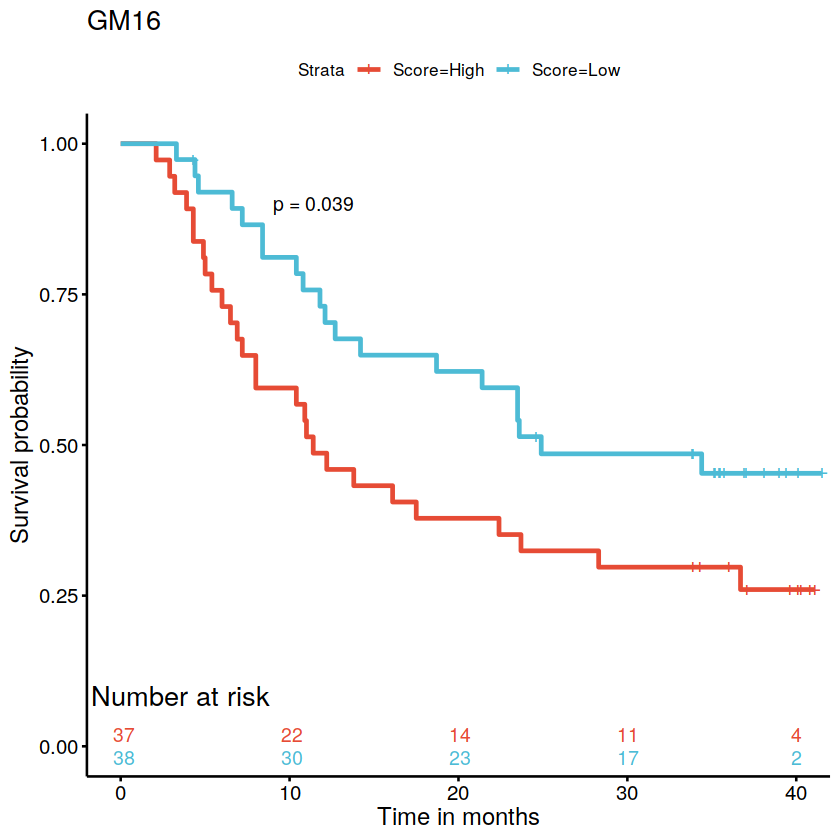

In [16]:
p = ggsurvplot(
    fit,                     # survfit object with calculated statistics.
    data = fibroblast_ratio, # data used to fit survival curves.
    risk.table = TRUE,       # show risk table.
    pval = TRUE,             # show p-value of log-rank test.
    #conf.int = TRUE,         # show confidence intervals for
    palette = "npg",
    xlab = "Time in months",   # customize X axis label.
    #ggtheme = theme_bw(),
    #conf.int.style = "step",  # customize style of confidence intervals  "ribbon" 'step'
    #surv.median.line = "hv",  # add the median survival pointer.
    # legend.labs = c("TP1", "TP2","TP3","TP4","TP5")    # change legend labels.
    #tables.y.text = T,
    risk.table.pos = "in",
    risk.table.col = "strata",
    fontsize = 4,
    pval.size = 4,
    #surv.plot.height = 0.8,
    #tables.height = 0.5,
    pval.coord = c(9, 0.9),
    legend = "top",
    title = "GM16"
  )
p

In [20]:
pdf(file = "../submit/figure/OS_survivalV5.pdf",width =6, height = 6, onefile = F)
print(p)
dev.off()

png 
  2

# figure: heterogeneity of patient

In [1]:
library(SeuratDisk)
library(dplyr)
library("sfsmisc")

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘sfsmisc’


The following object is masked from ‘package:dplyr’:

    last




In [2]:
sample_score = read.csv("/home/wyh/scdata/combined_data/Epithelial/submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_score = sample_score[,1:23]
diversity_score = read.csv("/home/wyh/scdata/combined_data/Epithelial/group_compare/adeno_p/diversity/diversity_score_PC30.csv",row.names = 1)
sample_score['diversity'] = diversity_score[rownames(sample_score),]
sample_score = sample_score[rownames(sample_score)[which(sample_score['diversity']!=max(sample_score['diversity']))],]

pdf("./submit/figure/GM16_diversity.pdf",height = 4,width = 4)
ggplot(sample_score, aes(score_GM16, diversity))+
        geom_point(size=1,shape=1)+
        geom_smooth(method = "rlm")+stat_cor( method = "spearman")+ylab("diversity")+xlab("score_GM16")+ggtitle("GM16")+theme_classic()
dev.off()

# figure: the robustness of the selection of K

In [24]:
gene_list_23genes = read.csv("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_23.csv",row.names = 1)
gene_list_26genes = read.csv("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_26.csv",row.names = 1)
gene_list_32genes = read.csv("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_32.csv",row.names = 1)
gene_list_36genes = read.csv("/home/wyh/scdata/combined_data/Epithelial/NMFV2/top_genes_36.csv",row.names = 1)

In [28]:
GM16_intersect_max = c()
for(K in c(20:49)){
    intersect_num = c()
#    union_num = c()
    gene_list = read.csv(paste0("/home/wyh/scdata/combined_data/Epithelial/NMFV2/robustness_analysis/top_genes_GM",K,".csv"),row.names = 1)
    for(i in 1:ncol(gene_list)){
        intersect_num = c(intersect_num,length(intersect(gene_list_23genes[,16],gene_list[,i])))
#        union_num = c(union_num,length(union(gene_list_23genes[,16],gene_list[,i])))
    }
    GM16_intersect_max = c(GM16_intersect_max,max(intersect_num))
}


In [29]:
data_plot = data.frame(K = c(20:49),overlap = GM16_intersect_max/100)

In [109]:
pdf("./submit/robustness.pdf",height = 4,width = 4)
ggplot(data_plot,aes(x = K,y = overlap))+geom_point(colour = "#0000FF", size = 2)+theme_classic()+
geom_line(colour = "#0000FF")+geom_vline(aes(xintercept = 23),linetype = "dashed")+
scale_x_continuous(breaks = seq(20,50,5))+scale_y_continuous(breaks = seq(0,1,0.2),limits = c(0,1))
dev.off()

png 
  2